In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../source')
sys.path.insert(0, '../scripts')
from shapely.geometry import Point, Polygon
from load_lakes import gdf
import geopandas as gpd


In [2]:
import metavars
metavars.lake_name = 'Cook_E2'        # set to 'synth' or one of the lakes in the inventory
lake_name = metavars.lake_name

In [3]:
from params import beta0,lamda0
print(beta0)
print(lamda0)

1.038566513352288
0.10918342160248565


In [4]:
dir_name = '../results/IS2_N_'+lake_name
!rm -r {dir_name};
!mkdir {dir_name}

Print the auxiliar parameters (ice thickness, basal drag, viscosity, velocities):

In [5]:
# print the auxiliary model parameters
from print_params import print_params
print_params()

auxiliary model parameters:
H = 2.694513916015625 km
beta = 2.70e+12 Pa s m^-1
eta = 3.50e+15 Pa s
u = 0.8187565365481373 m yr^-1
v = -0.23050711909590707 m yr^-1
relaxation time = 9.158899632590687 yr


Calculate the effective pressure!

In [6]:
from kernel_fcns import fftd,ifftd,C_h,C_w
from params import results_dir,data_dir,lamda0,delta,x0,y0,t0,H,N_sc
from post_process import calc_s

# load elevation data (h_obs)
h = np.load(results_dir+'/h_fwd.npy')
w = np.load(results_dir+'/w_inv.npy')
s = calc_s(w,initial=0) + h[0,:,:]
h_ft = fftd(h)
w_ft = fftd(w)
s_ft = fftd(s)
N_ft = (1/lamda0)*C_w()*w_ft - C_h()*h_ft - delta*s_ft
N = ifftd(N_ft).real


In [7]:
np.save(dir_name+'/N.npy',N)
np.save(dir_name+'/w.npy',w)
np.save(dir_name+'/h.npy',h)
np.save(dir_name+'/x.npy',x0)
np.save(dir_name+'/y.npy',y0)
np.save(dir_name+'/t.npy',t0)

In [13]:
poly_list = []
outlines = gpd.GeoSeries(poly_list)

In [14]:
%matplotlib tk
x_d = np.load(data_dir+'/x_d.npy')
y_d = np.load(data_dir+'/y_d.npy')
N_ = np.copy(N)
i = 55
if lake_name == 'Mac1':
    i=40
fig = plt.figure(figsize=(12,6))
levels= np.linspace(-5,5,6)
ticks= np.linspace(-5,5,6)


plt.title(r'choose lake boundary!',fontsize=20)
p = plt.contourf(x_d,y_d,N_[i,:,:]*N_sc/1e3,levels=levels,cmap='PuOr_r',extend='both')
if outlines.size>0:
    outlines.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.xlabel(r'$x$ (km)',fontsize=20)
plt.ylabel(r'$y$ (km)',fontsize=20)
cbar = plt.colorbar(p,ticks=ticks,orientation='horizontal', fraction=0.05, pad=0.15)
cbar.ax.tick_params(labelsize=14)   
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar.set_label(r'$N$ (kPa)', fontsize=20)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
pts = plt.ginput(-1,timeout=-1)
poly_list.append(Polygon(pts))
outlines = gpd.GeoSeries(poly_list)
outlines.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.pause(2)
plt.close()

In [15]:
outline = outlines[0]
x_d = np.load(data_dir+'/x_d.npy')
y_d = np.load(data_dir+'/y_d.npy')
xp,yp = np.meshgrid(x_d,y_d)
outline_prev = gdf.loc[gdf['name']==lake_name]
bdry = 0*xp 
for i in range(x_d.size):
    for j in range(y_d.size):
        point = Point(x_d[i],y_d[j])
        bdry[i,j] = outline.contains(point)

In [16]:
def get_means(N,w,h,bdry):
    N_mean = np.zeros(N.shape[0])
    w_mean = np.zeros(w.shape[0])
    h_mean = np.zeros(h.shape[0])

    for i in range(N.shape[0]):
        N_i = N[i,:,:]
        w_i = w[i,:,:]
        h_i = h[i,:,:]

        N_mean[i] = N_i[bdry.T>1e-2].mean()
        w_mean[i] = w_i[bdry.T>1e-2].mean()
        h_mean[i] = h_i[bdry.T>1e-2].mean()
    return N_mean, w_mean, h_mean   

N_mean, w_mean, h_mean   = get_means(N,w,h,bdry)
np.save(dir_name+'/N_mean.npy',N_mean)
np.save(dir_name+'/w_mean.npy',w_mean)
np.save(dir_name+'/h_mean.npy',h_mean)
np.save(dir_name+'/bdry.npy',bdry)

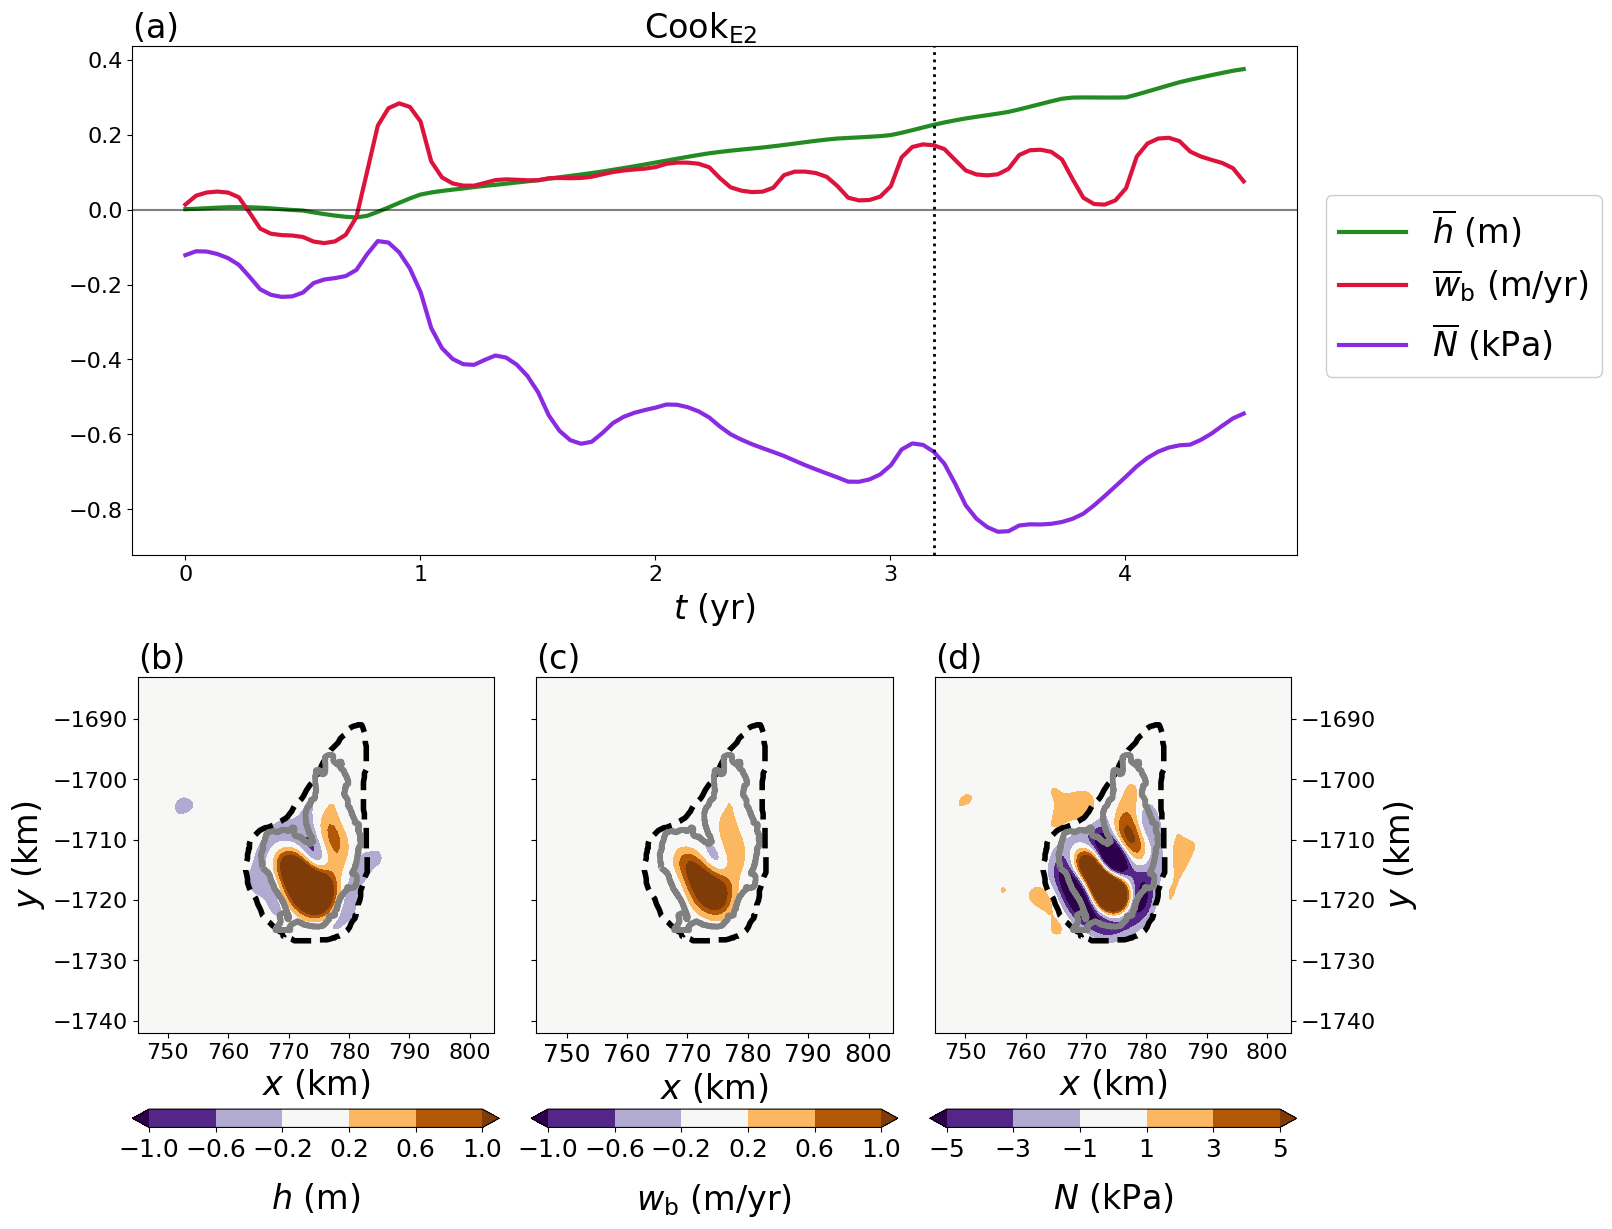

In [18]:
%matplotlib inline

xp,yp = np.meshgrid(x_d,y_d)

l = 70
if lake_name == 'Mac1':
    l=28

# l1 = np.argmin(np.abs(t0-1.3))

j0 = int(0.0*t0.size)
plt.figure(figsize=(16,12.5))
#Cook$_{\mathrm{E}2}$
#Byrd$_{\mathrm{s}10}$
plt.subplot(211)
plt.title(r'(a)$\qquad\qquad\qquad\qquad\qquad\qquad\qquad$'+r' Cook$_{\mathrm{E}2}$',loc='left',fontsize=24)
plt.plot(t0[j0:None],h_mean[j0:None],color='forestgreen',linewidth=3,label=r'$\overline{h}$ (m)')
plt.plot(t0[j0:None],w_mean[j0:None],color='crimson',linewidth=3,label=r'$\overline{w}_\mathrm{b}$ (m/yr)')
plt.plot(t0[j0:None],N_mean[j0:None]*N_sc/1e3,color='blueviolet',linewidth=3,label=r'$\overline{N}$ (kPa)')
plt.axvline(x=t0[l],color='k',linestyle=':',linewidth=2)
# plt.axvline(x=t0[l1],color='k',linestyle=':',linewidth=2)
plt.axhline(y=0,color='k',linestyle='-',alpha=0.5)
plt.xlabel(r'$t$ (yr)',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=24,loc=(1.025,0.35),framealpha=1)

plt.subplot(234)
plt.title('(b)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,h[l,:,:],cmap='PuOr_r',levels=np.linspace(-1,1,6),extend='both')
# plt.contour(xp,yp,bdry.T,colors='gold',linewidths=2,levels=[1e-2])
outline = gpd.GeoSeries(outlines[0])
outline.plot(edgecolor='k',linestyle='--',facecolor='none',ax=plt.gca(),linewidth=4)
outline_prev.plot(edgecolor='gray',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=4)
cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$h$ (m)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)
plt.gca().set_aspect('equal', 'box')


plt.subplot(235)
plt.title('(c)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,w[l,:,:],cmap='PuOr_r',levels=np.linspace(-1,1,6),extend='both')
outline = gpd.GeoSeries(outlines[0])
outline.plot(edgecolor='k',linestyle='--',facecolor='none',ax=plt.gca(),linewidth=4)
outline_prev.plot(edgecolor='gray',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=4)
cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$w_\mathrm{b}$ (m/yr)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.gca().yaxis.set_ticklabels([])
plt.gca().set_aspect('equal', 'box')

plt.subplot(236)
plt.title('(d)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,N[l,:,:]*N_sc/1e3,cmap='PuOr_r',levels=np.linspace(-5,5,6),extend='both')
outline = gpd.GeoSeries(outlines[0])
outline.plot(edgecolor='k',linestyle='--',facecolor='none',ax=plt.gca(),linewidth=4)
outline_prev.plot(edgecolor='gray',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=4)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)
plt.gca().set_aspect('equal', 'box')

cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$N$ (kPa)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
if lake_name == 'MercerSubglacialLake':
    plt.savefig('fig6')
elif lake_name == 'Mac1':
    plt.savefig('fig7')
elif lake_name == 'Byrd_s10':
    plt.savefig('fig9')  
elif lake_name == 'Cook_E2':
    plt.savefig('fig10')      
plt.show()
plt.close()